# Chainlink RAI/USD TWAP Analysis

## Purpose
Explore Chainlink RAI/USD and Reflexer TWAP of Chainlink RAI/USD

In [2]:
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from graph_util import fetch_medianizer

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200 

## Prep data

#### Chainlink TWAP

In [4]:
df_twap = pd.read_csv('new_twap.csv')

In [5]:
df_twap['price'] /= 1E18

In [6]:
df_twap['time'] = pd.to_datetime(df_twap['ts'], unit='s', utc=True)
df_twap['time_1m'] = df_twap['time'].dt.round('1min') 
df_twap = df_twap.drop_duplicates(['time_1m']) 
df_twap = df_twap.set_index('time_1m').drop(['ts', 'time', 'block'], axis=1).rename(columns={'price': 'rai_usd'})
df_twap = df_twap.asfreq('1min', method='ffill')

In [7]:
df_twap.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54935 entries, 2021-10-23 16:07:00+00:00 to 2021-11-30 19:41:00+00:00
Freq: T
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   rai_usd  54935 non-null  float64
dtypes: float64(1)
memory usage: 858.4 KB


#### Chainlink RAI/USD Feed

In [8]:
df_cl = pd.read_csv('Aggregated-answer-12-1.csv')

In [9]:
df_cl['time'] = pd.to_datetime(df_cl['Answer'], utc=True)
df_cl['time_1m'] = df_cl['time'].dt.round('1min') 
df_cl = df_cl.drop_duplicates(['time_1m']) 
df_cl = df_cl.set_index('time_1m').drop(['Answer', 'time'], axis=1).rename(columns={'RAI / USD': 'rai_usd'})
df_cl = df_cl.asfreq('1min', method='ffill')

#### Coingecko RAI/USD

In [11]:
df_cg = pd.read_csv('rai_usd_cg.csv')

In [12]:
df_cg['time'] = pd.to_datetime(df_cg['time'], utc=True)
df_cg['time_1m'] = df_cg['time'].dt.round('1min') 
df_cg = df_cg.drop_duplicates(['time_1m']) 
df_cg = df_cg.set_index('time_1m').drop(['time'], axis=1)#.rename(columns={'RAI / USD': 'rai_usd'})
df_cg = df_cg.asfreq('1min', method='ffill')

In [13]:
df_cg.head(3)

,rai_usd
time_1m,
2021-10-20 00:02:00+00:00,3.03
2021-10-20 00:03:00+00:00,3.03
2021-10-20 00:04:00+00:00,3.03


#### UniV2 RAI/ETH * Chainlink ETH/USD

In [14]:
df_rt = pd.read_csv('rai_usd_realtime.csv')

In [15]:
df_rt['time'] = pd.to_datetime(df_rt['time'], utc=True)
df_rt['time_1m'] = df_rt['time'].dt.round('1min') 
df_rt = df_rt.drop_duplicates(['time_1m']) 
df_rt = df_rt.set_index('time_1m').drop(['time'], axis=1)
df_rt = df_rt.asfreq('1min', method='ffill')

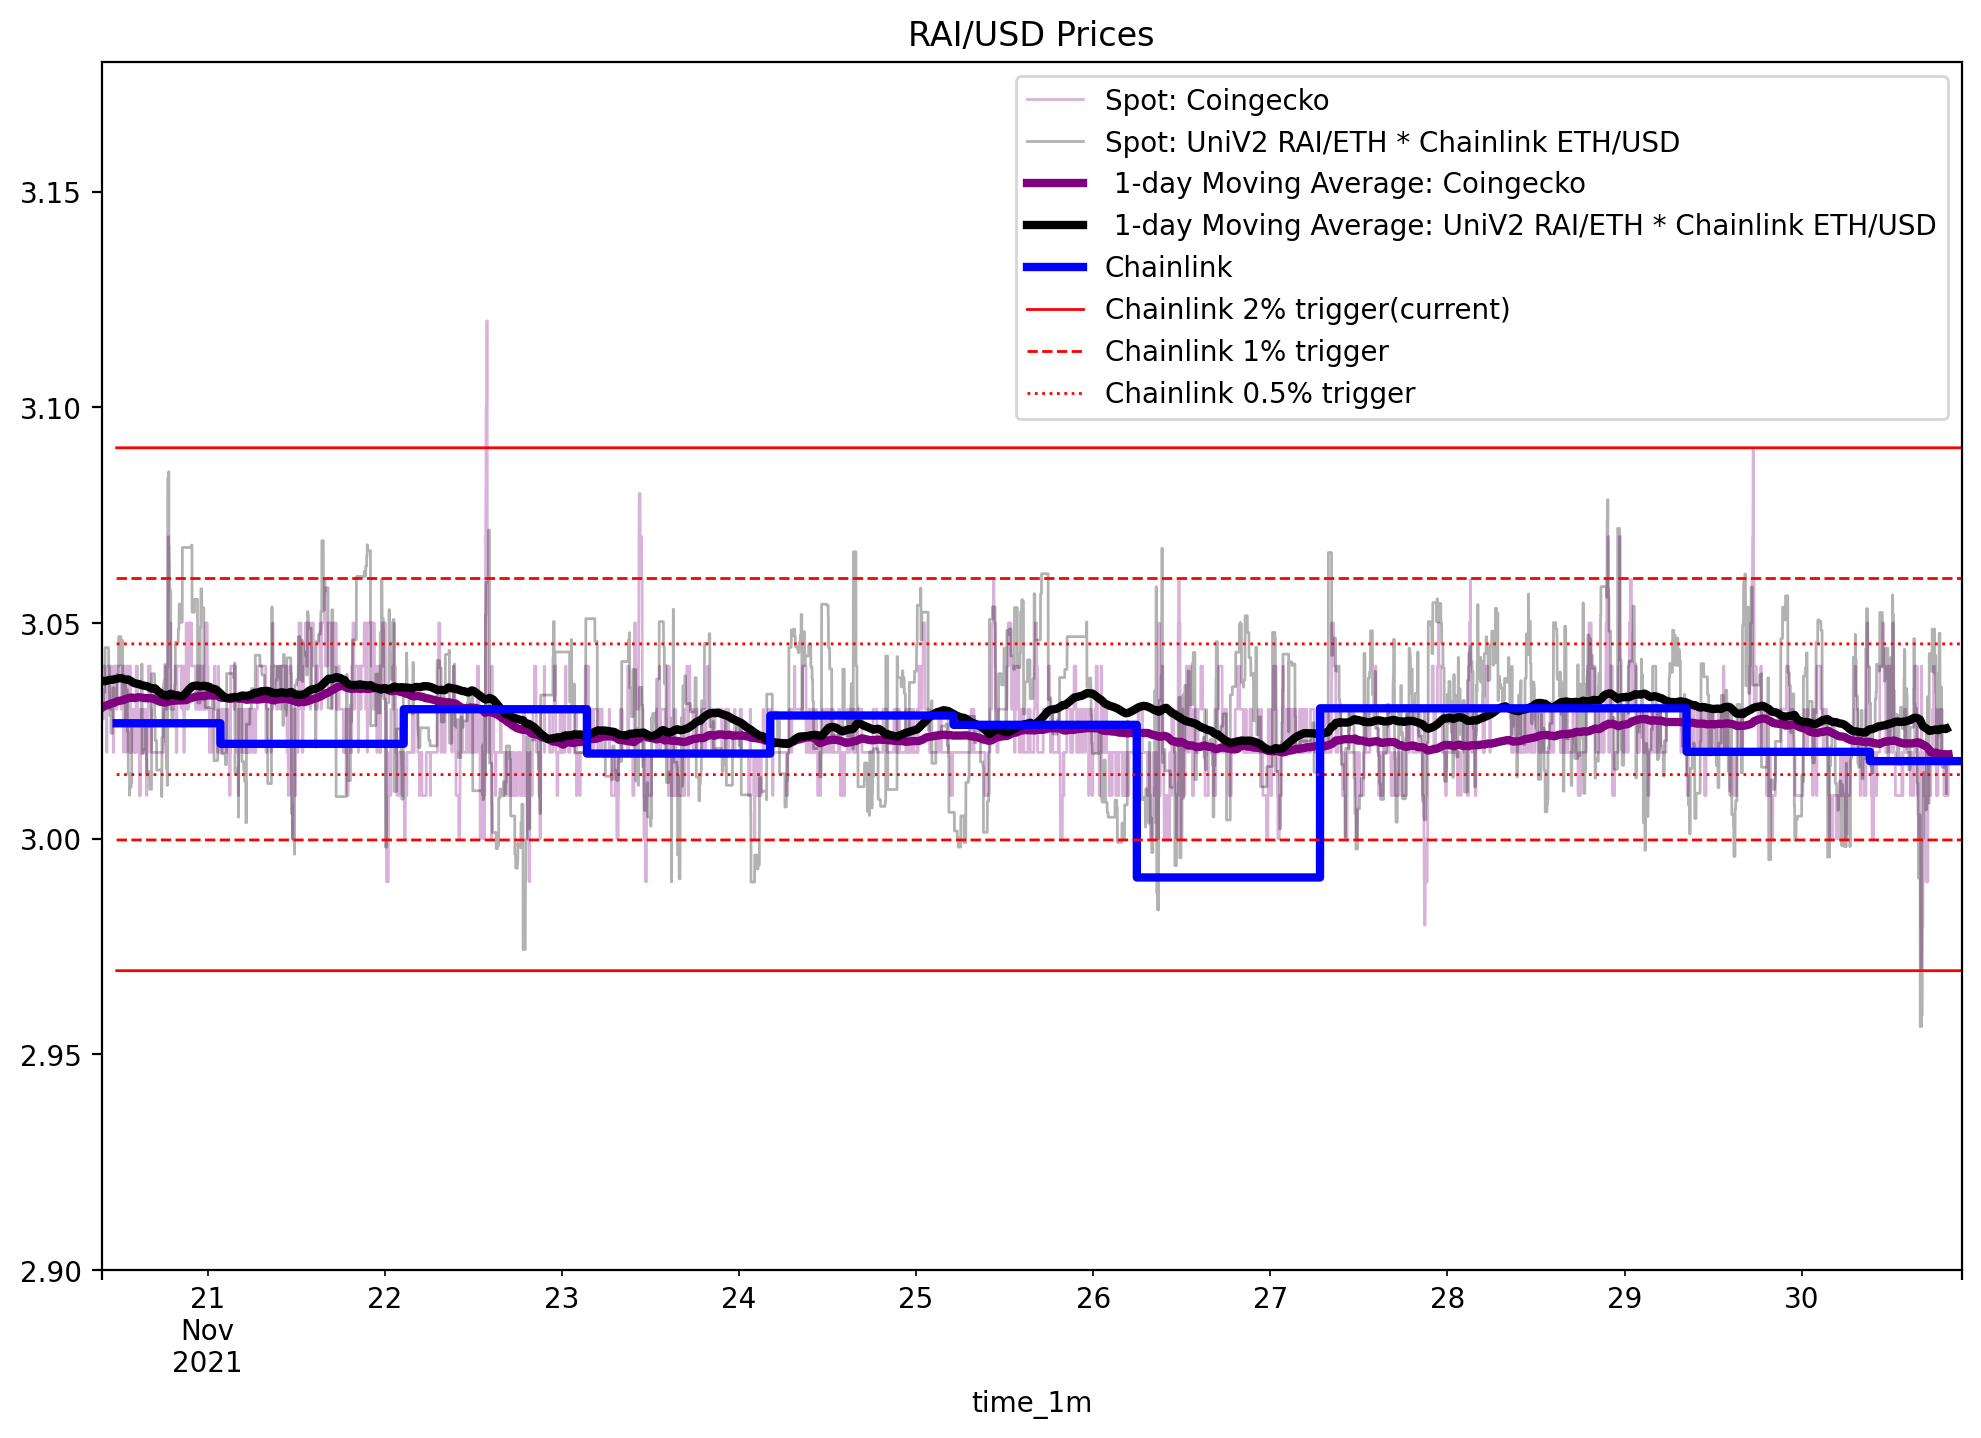

In [37]:
fig, ax = plt.subplots(1, 1)

# Number of recent minutes to plot
n = 15000

# Spot RAI/USD
df_cg['rai_usd'][-n:].plot(lw=1, alpha=0.3, ax=ax, label='Spot: Coingecko', color='purple')
df_rt['rai_usd'][-n:].plot(lw=1, alpha=0.3, ax=ax, label='Spot: UniV2 RAI/ETH * Chainlink ETH/USD', color='black')

# Spot RAI/USD moving averages
df_cg['rai_usd'].rolling('1D').mean()[-n:].plot(lw=3, alpha=1, ax=ax, label=' 1-day Moving Average: Coingecko', color='purple')
df_rt['rai_usd'].rolling('1D').mean()[-n:].plot(lw=3, alpha=1, ax=ax, label=' 1-day Moving Average: UniV2 RAI/ETH * Chainlink ETH/USD', color='black')

# Chainlink RAI/USD
df_cl['rai_usd'][-n:].plot(lw=3, alpha=1, ax=ax, label='Chainlink', color='blue')


# Calculate and plot possible chainlink deviation thresholds
RP = 3.03
ax.set_ylim((2.90, 3.18))
df_cl['upper_2pct_trigger'] = RP * 1.02
df_cl['lower_2pct_trigger'] = RP * 0.98
df_cl['upper_1pct_trigger'] = RP * 1.01
df_cl['lower_1pct_trigger'] = RP * 0.99
df_cl['upper_05pct_trigger'] = RP * 1.005
df_cl['lower_05pct_trigger'] = RP * 0.995

df_cl['upper_2pct_trigger'][-n:].plot(lw=1, alpha=1, ax=ax, label='Chainlink 2% trigger(current)', color='red')
df_cl['upper_1pct_trigger'][-n:].plot(style='--', lw=1, alpha=1, ax=ax, label='Chainlink 1% trigger', color='red')
df_cl['upper_05pct_trigger'][-n:].plot(style=':', lw=1, alpha=1, ax=ax, label='Chainlink 0.5% trigger', color='red')

ax.legend(loc='upper right')

df_cl['lower_2pct_trigger'][-n:].plot( lw=1, alpha=1, ax=ax, color='red')
df_cl['lower_1pct_trigger'][-n:].plot(style='--', lw=1, alpha=1, ax=ax, color='red')
df_cl['lower_05pct_trigger'][-n:].plot(style=':', lw=1, alpha=1, ax=ax, color='red')

plt.title('RAI/USD Prices')
plt.xticks(fontsize=8);

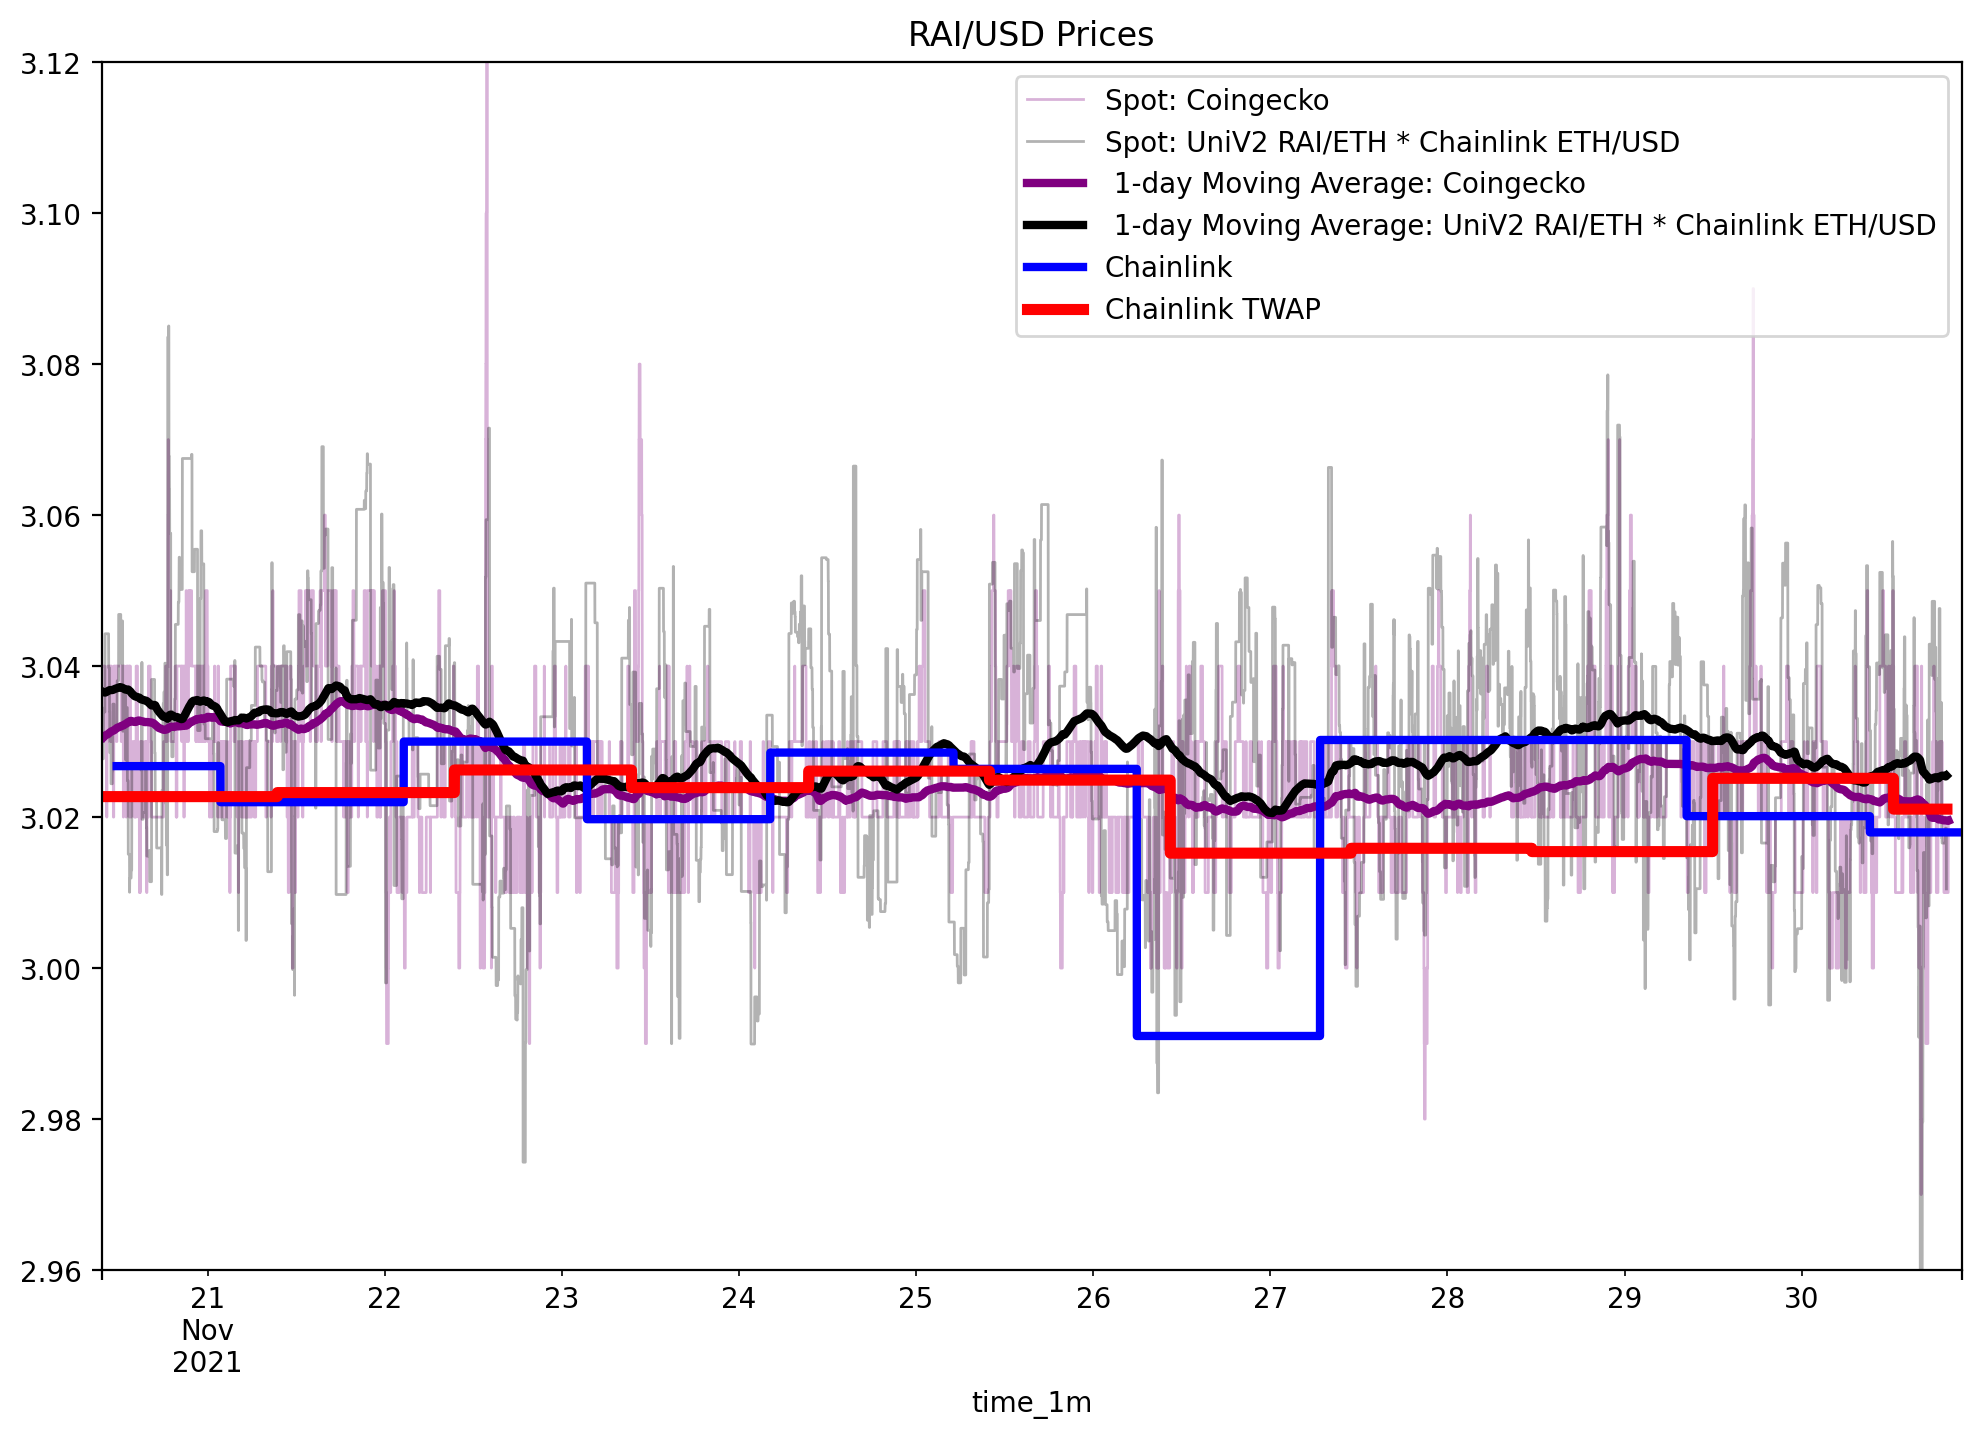

In [38]:
fig, ax = plt.subplots(1, 1)
n = 15000

# Spot RAI/USD
df_cg['rai_usd'][-n:].plot(lw=1, alpha=0.3, ax=ax, label='Spot: Coingecko', color='purple')
df_rt['rai_usd'][-n:].plot(lw=1, alpha=0.3, ax=ax, label='Spot: UniV2 RAI/ETH * Chainlink ETH/USD', color='black')

# Spot RAI/USD moving averages
df_cg['rai_usd'].rolling('1D').mean()[-n:].plot(lw=3, alpha=1, ax=ax, label=' 1-day Moving Average: Coingecko', color='purple')
df_rt['rai_usd'].rolling('1D').mean()[-n:].plot(lw=3, alpha=1, ax=ax, label=' 1-day Moving Average: UniV2 RAI/ETH * Chainlink ETH/USD', color='black')

# Chainklink RAI/USD Feed
df_cl['rai_usd'][-n:].plot(lw=3, alpha=1, ax=ax, label='Chainlink', color='blue')

# Reflexer Chainlink TWAP
df_twap['rai_usd'][-n:].plot(lw=4, ax=ax, label='Chainlink TWAP', color='red')

ax.legend(loc='upper right')

ax.set_ylim((2.96, 3.12))
plt.title('RAI/USD Prices')
plt.xticks(fontsize=8);

Same plot as above, just larger window

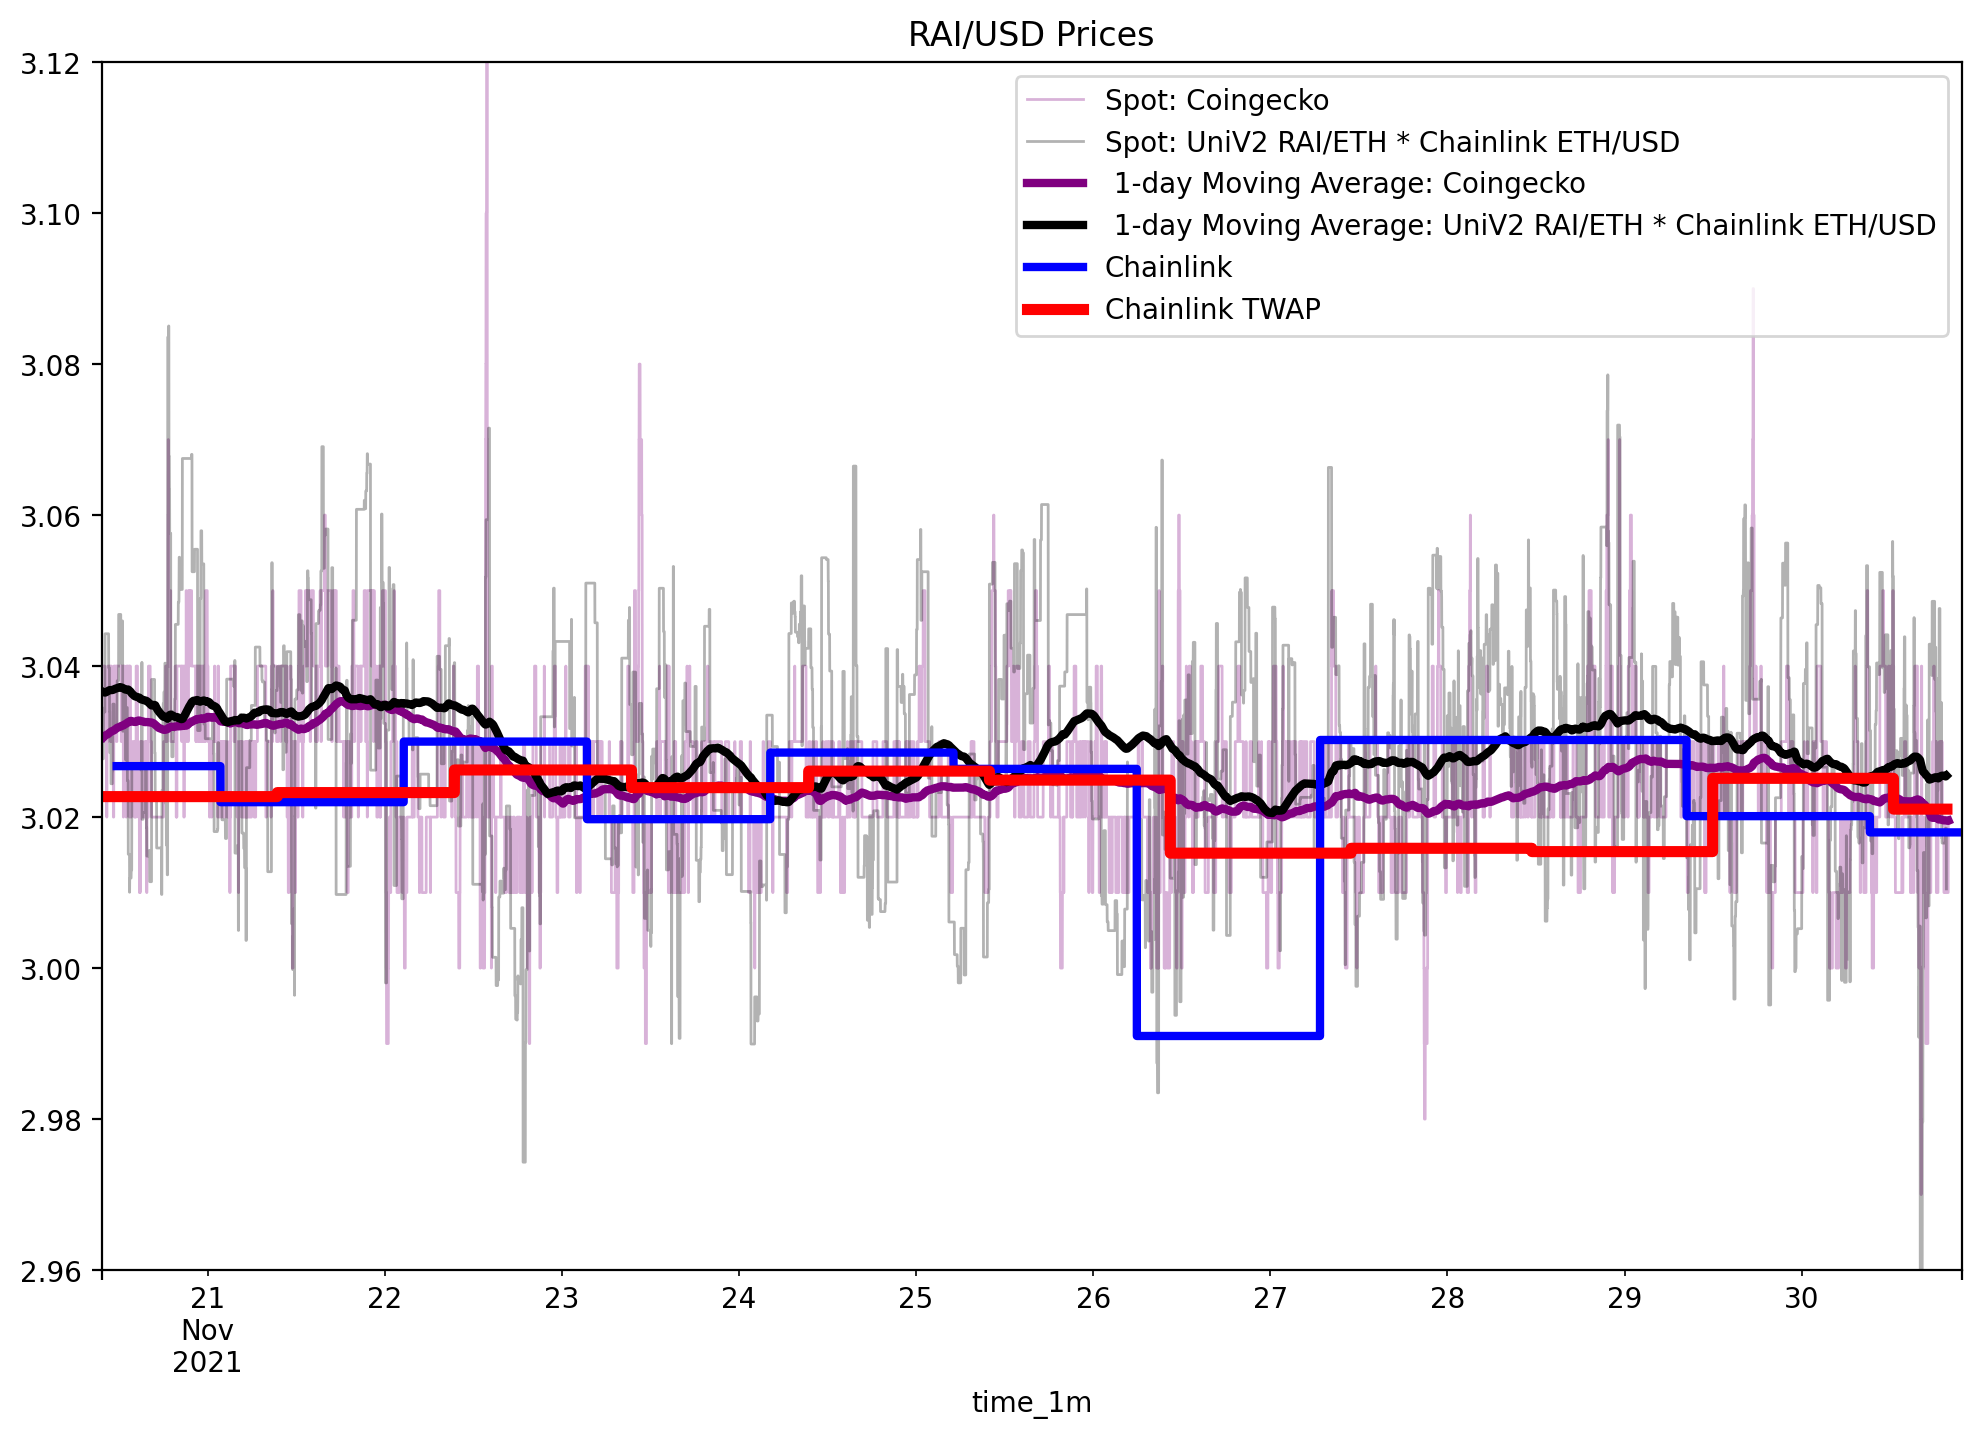

In [38]:
fig, ax = plt.subplots(1, 1)
n = 45000

# Spot RAI/USD
df_cg['rai_usd'][-n:].plot(lw=1, alpha=0.3, ax=ax, label='Spot: Coingecko', color='purple')
df_rt['rai_usd'][-n:].plot(lw=1, alpha=0.3, ax=ax, label='Spot: UniV2 RAI/ETH * Chainlink ETH/USD', color='black')

# Spot RAI/USD moving averages
df_cg['rai_usd'].rolling('1D').mean()[-n:].plot(lw=3, alpha=1, ax=ax, label=' 1-day Moving Average: Coingecko', color='purple')
df_rt['rai_usd'].rolling('1D').mean()[-n:].plot(lw=3, alpha=1, ax=ax, label=' 1-day Moving Average: UniV2 RAI/ETH * Chainlink ETH/USD', color='black')

# Chainklink RAI/USD Feed
df_cl['rai_usd'][-n:].plot(lw=3, alpha=1, ax=ax, label='Chainlink', color='blue')

# Reflexer Chainlink TWAP
df_twap['rai_usd'][-n:].plot(lw=4, ax=ax, label='Chainlink TWAP', color='red')

ax.legend(loc='upper right')

ax.set_ylim((2.96, 3.12))
plt.title('RAI/USD Prices')
plt.xticks(fontsize=8);